[Scale] Independent scales: s_lr=0.448453 (|LR|->1), s_gt=0.00137736 (GT->[0,1])
[Stats] GT:     min=0, max=1
[Stats] |LR|:   max=1
[Stats] |recon_raw|:  max=0.2323
[Stats] |recon_corr|: max=0.2473


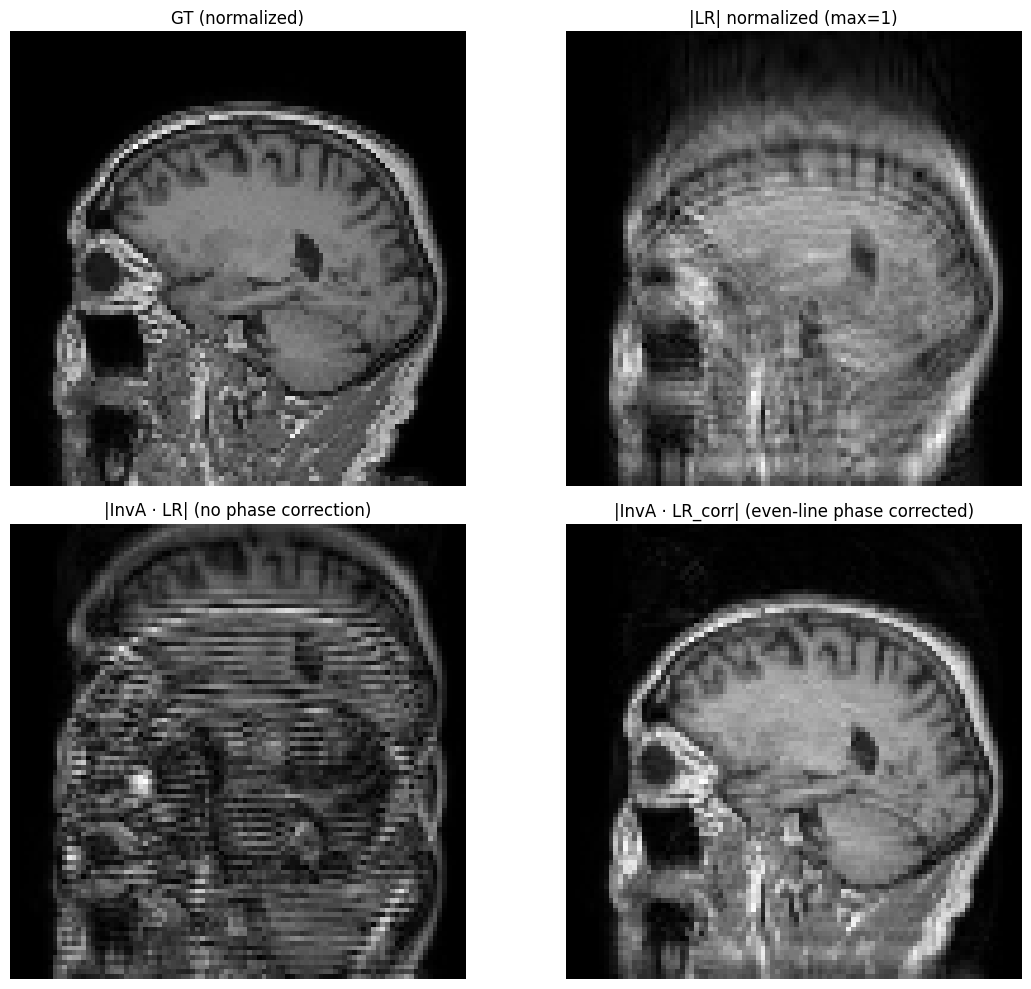

In [18]:
import os
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.io import loadmat

from sys import path
path.append("/home/data1/musong/workspace/2025/8/08-20/spenpy")
from spenpy.spen import spen

# ---------------- Config ----------------
root_path = "/home/data1/musong/workspace/2025/8/08-20/tr/data/IXI_sim"
idx_name  = "IXI458-Guys-0993-T1_idx0008.mat"   # single-slice filename

# Normalization strategy:
# False -> Independent scales (GT max=1, |LR| max=1)
# True  -> Shared single scale derived from LR (|LR| max=1) and applied to GT too
USE_SHARED_SCALE = False

# ---------------- Load ----------------
data_fp  = os.path.join(root_path, "data", idx_name)
final_fp = os.path.join(root_path, "final_rxyacq_ROFFT", idx_name)
phase_fp = os.path.join(root_path, "phase_map", idx_name)

data_np  = loadmat(data_fp)["data"]                    # float32, (w,h)
final_np = loadmat(final_fp)["final_rxyacq_ROFFT"]     # complex64, (w,h)
phase_np = loadmat(phase_fp)["phase_map"]              # float32, (w/2,h)

# Torch tensors with batch dim -> (1,w,h)
data_t  = torch.from_numpy(np.asarray(data_np,  dtype=np.float32)).unsqueeze(0)
final_t = torch.from_numpy(np.asarray(final_np, dtype=np.complex64)).unsqueeze(0)
phase_t = torch.from_numpy(np.asarray(phase_np, dtype=np.float32)).unsqueeze(0)

# ---------------- Build InvA ----------------
# (acq_point) must match the spatial size of your saved slice
sim = spen(acq_point=data_t.shape[-2:])
InvA, AFinal = sim.get_InvA()   # not directly used here except InvA for recon

# ---------------- Normalize ----------------
eps = 1e-12

if USE_SHARED_SCALE:
    # Derive one scale from LR so that max|LR| = 1; apply same to GT
    s = 1.0 / (torch.abs(final_t).amax() + eps)
    final_t_n = final_t * s
    data_t_n  = data_t  * s
    print(f"[Scale] Shared scale s={float(s):.6g}  -> max|LR|=1; GT scaled by same s")
else:
    # Independent normalization:
    #   - LR: make max|LR| = 1
    #   - GT: make max(GT) = 1
    s_lr = 1.0 / (torch.abs(final_t).amax() + eps)
    s_gt = 1.0 / (data_t.amax() + eps)
    final_t_n = final_t * s_lr
    data_t_n  = data_t  * s_gt
    print(f"[Scale] Independent scales: s_lr={float(s_lr):.6g} (|LR|->1), s_gt={float(s_gt):.6g} (GT->[0,1])")

# NOTE: Phase map is in radians (dimensionless). Do NOT scale it.
phase_t_n = phase_t

# ---------------- Apply even-line phase correction in k-space ----------------
# (Assuming your acquisition places the phase error on even lines along dim=-2)
EvenData = final_t_n[:, 1::2, :].clone()
EvenData *= torch.exp(-1j * phase_t_n)         # remove phase on even lines
final_corr = final_t_n.clone()
final_corr[:, 1::2, :] = EvenData

# ---------------- Reconstructions ----------------
# Recon without correction (to visualize impact) and with correction
with torch.no_grad():
    recon_raw  = torch.matmul(InvA, final_t_n)     # complex (1,w,h)
    recon_corr = torch.matmul(InvA, final_corr)    # complex (1,w,h)

# ---------------- Sanity prints ----------------
print(f"[Stats] GT:     min={float(data_t_n.min()):.4g}, max={float(data_t_n.max()):.4g}")
print(f"[Stats] |LR|:   max={float(torch.abs(final_t_n).amax()):.4g}")
print(f"[Stats] |recon_raw|:  max={float(torch.abs(recon_raw).amax()):.4g}")
print(f"[Stats] |recon_corr|: max={float(torch.abs(recon_corr).amax()):.4g}")

# ---------------- Plot ----------------
plt.figure(figsize=(12, 10))

plt.subplot(2,2,1)
plt.imshow(data_t_n[0].cpu().numpy(), cmap='gray')
plt.title('GT (normalized)')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(torch.abs(final_t_n[0]).cpu().numpy(), cmap='gray')
plt.title('|LR| normalized (max=1)')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(torch.abs(recon_raw[0]).cpu().numpy(), cmap='gray')
plt.title('|InvA · LR| (no phase correction)')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(torch.abs(recon_corr[0]).cpu().numpy(), cmap='gray')
plt.title('|InvA · LR_corr| (even-line phase corrected)')
plt.axis('off')

plt.tight_layout()
plt.show()
